# Cat and Mouse in a House

In [48]:
from header import *
%matplotlib inline
import matplotlib.pyplot as plt

Nez the mouse is lost in the house below.

<img src="house.png", width=169, height=239 alt="house">

He searches for his hole via simple random walk - he randomly jumps to any of the rooms adjacent to his current room with equal probability. Nez’s hole is in room 8; he will stay here (in safety) if he ever makes it. However, Brodie the cat lives in room 6 - she will eat Nez if he enters her room. Clearly, Nez will eventually be “absorbed”, either into his hole or into Brodie’s belly.
Consider the following scenarios:
1. Nez starts in room 0
2. Nez starts in room 1
3. Nez starts in room 5

For each scenario, answer the folliowing 2 questions.
1. What is the probability that Nez gets eaten? What is the probabilty that Nez gets home safely? (aka - where is he absorbed)
2. How many moves does he make before he gets “absorbed”? (aka - when is he absorbed) Please give the average absorption time AND plot a histogram of the distribution of absorption times (showing what proportion of samples get absorbed after 1 jump, 2 jumps, 3 jumps, etc). Do a search for creating histograms in python - you will likely want to use the matplotlib package.

In [21]:
def architecture_check_passed(transition_matrix, initial_distribution_matrix):
    num_of_states = transition_matrix.shape[0]
    if initial_distribution_matrix.shape[0] != num_of_states:
        #print("Transition matrix and initial distribution dimensions don't match")
        return False

    row_sums  = np.sum(transition_matrix, 1)
    should_be = np.ones_like(row_sums)
    if np.allclose(row_sums, should_be) == False:
        #print('Rows of transition matrix do not all sum to 1')
        return False
    return True

In [73]:
def sample_evolution(initial_parameters):
    # unpack list
    num_of_steps                = initial_parameters[0]
    num_of_records              = initial_parameters[1]
    num_of_states               = initial_parameters[2]
    num_of_samples              = initial_parameters[3]
    transition_matrix           = initial_parameters[4]
    initial_distribution_matrix = initial_parameters[5]
    
    ### -------------- set stage for simulation -------------- ###
    # create empirical probability distribution function
    epdf    = np.zeros([num_of_records, num_of_states], dtype = float)
    # initial the epdf by writing the initial distribution matrix to epdf
    epdf[0] = initial_distribution_matrix[:]
    #printltx(r"initialized epdf = " + ltxmtx(epdf))
    
    scaled_initial_distribution_matrix = np.rint(initial_distribution_matrix*num_of_samples).astype(int)
    simulation_ledger                  = np.zeros([num_of_records, num_of_samples], dtype = int)

    # initialize simulation ledger by distributing probabilities
    # from the initial distribution matrix to the sample population
    simulation_ledger_index_1 = 0
    for state_index in range(num_of_states):
        simulation_ledger_index_2 = simulation_ledger_index_1 + scaled_initial_distribution_matrix[state_index]
        simulation_ledger[0, simulation_ledger_index_1:simulation_ledger_index_2] = state_index
        simulation_ledger_index_1 = simulation_ledger_index_2
    # shuffle the columns in the first row
    np.random.shuffle(simulation_ledger[0])
    
    ### -------------- run the simulation -------------- ###
    absorption_states = [6, 8]
    # vector to record how many steps until first return to an absorption state
    first_return_absorption = np.zeros(num_of_samples, dtype = int)
    for step in range(num_of_steps):
        # "step" here refers to the location with respect to the number of records
        # since we're looping through the same array
        current_step = step % num_of_records
        next_step    = (step + 1) % num_of_records
        for sample in range(num_of_samples):
            current_state      = simulation_ledger[current_step, sample]
            # choose random number between 0 and 1
            random_probability = np.random.rand()
            # randomly decide which state sample goes to next
            for next_state in range(num_of_states):
                random_probability -= transition_matrix[current_state, next_state]
                if random_probability < 0:
                    simulation_ledger[next_step, sample] = next_state
                    if next_state not in absorption_states:                        
                        first_return_absorption[sample] += 1
                    break
        epdf[next_step, :] = np.histogram(simulation_ledger[next_step, :], \
                                          normed = True, bins = range(num_of_states + 1))[0]
    
    average_absorption_time = np.sum(first_return_absorption) / num_of_samples
    printltx(r"Average absorption time is " + str(average_absorption_time))
    plt.title('Distribution of Absorption Times')
    plt.hist(first_return_absorption, bins = range(np.max(first_return_absorption)))
    plt.xlabel('jumps')
    plt.ylabel('frequency')
    plt.show()
    
    # right now, the last distribution is not necessarily on the bottom of the epdf matrix;
    # so, the following code rearranges the rows of the matrix to make sure the final distribution is on bottom
    epdf = np.roll(epdf, num_of_records - next_step - 1, axis = 0)
    return epdf

In [23]:
def matrix_multiplication_evolution(initial_parameters):
    # unpack list
    num_of_steps                = initial_parameters[0]
    num_of_records              = initial_parameters[1]
    num_of_states               = initial_parameters[2]
    transition_matrix           = initial_parameters[3]
    initial_distribution_matrix = initial_parameters[4]
    
    ### -------------- set stage for simulation -------------- ###
    # create ________ probability distribution function
    tpdf    = np.zeros([num_of_records, num_of_states], dtype = float)
    # initialize the tpdf by writing the initial distribution matrix to tpdf
    tpdf[0] = initial_distribution_matrix[:]
    printltx(r"initialized tpdf = " + ltxmtx(tpdf))
    
    ### -------------- run the simulation -------------- ###
    absorption_states = [6, 8]
    # vector to record how many steps until first return to an absorption state
    first_return_absorption = np.zeros(num_of_samples, dtype = int)
    for step in range(num_of_steps):
        current_step       = step % num_of_records
        next_step          = (step + 1) % num_of_records
        tpdf[next_step, :] = tpdf[current_step, :].dot(transition_matrix)
        if next_state not in absorption_states:                        
                        first_return_absorption[sample] += 1
    
    # right now, the last distribution is not necessarily on the bottom of the epdf matrix;
    # so, the following code rearranges the rows of the matrix to make sure the final distribution is on bottom
    tpdf = np.roll(tpdf, num_of_records - next_step - 1, axis = 0)
    
    return tpdf

In [35]:
def print_conclusions(num_of_steps, num_of_records, num_of_samples, pdf, method):
    if method == 'sample_evolution':
        printltx(r"I did " + str(num_of_steps) + " steps with " + str(num_of_samples) + \
                 " samples. The last " + str(num_of_records) + \
                 " distributions are written as below:")
        display(pdf)
        printltx(r"The average of these distributions, $\vec{\pi}$, is " + ltxmtx(np.mean(pdf, 0)))
        printltx(r"The probability that Nez gets eaten is " + str(np.mean(pdf, 0)[6]))
        printltx(r"The probability that Nez gets home safely is " + str(np.mean(pdf, 0)[8]))
    if method == 'matrix_multiplication_evolution':
        printltx(r"I did " + str(num_of_steps) + " steps. The last " + \
                 str(num_of_records) + " distributions are written as below:")
        display(pdf)
        printltx(r"The average of these distributions, $\vec{\pi}$, is " + ltxmtx(np.mean(pdf, 0)))
    if method == 'eigen_future':
        return None

Define vaious initial distributions that represent where the mouse starts in the house.

In [29]:
phi0 = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0])
phi1 = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0])
phi5 = np.array([0, 0, 0, 0, 0, 1, 0, 0, 0])
initial_distributions = [phi0, phi1, phi5]

Define transition matrix that's a 3x3 grid since we have 9 states. This random walk will be a simple one.

In [26]:
P = np.array([[0, .5, 0, .5, 0, 0, 0, 0, 0], [1/3, 0, 1/3, 0, 1/3, 0, 0, 0, 0], [0, .5, 0, 0, 0, .5, 0, 0, 0], \
              [1/3, 0, 0, 0, 1/3, 0, 1/3, 0, 0], [0, 1/4, 0, 1/4, 0, 1/4, 0, 1/4, 0], [0, 0, 1/3, 0, 1/3, 0, 0, 0, 1/3], \
              [0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 1/3, 0, 1/3, 0, 1/3], [0, 0, 0, 0, 0, 0, 0, 0, 1]])

Initialize parameters.

In [32]:
num_of_steps   = 1000
num_of_records = 10
num_of_states  = phi0.shape[0]
num_of_samples = 2000

## Solution via Sample Evolution

<IPython.core.display.Latex object>

---------------------------------------------------------------------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

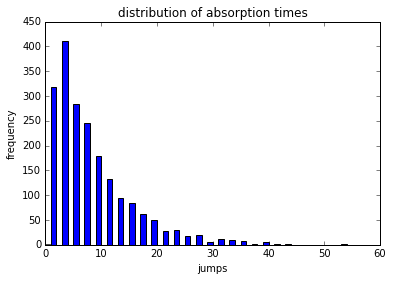

<IPython.core.display.Latex object>

array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.6185,
         0.    ,  0.3815],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.6185,
         0.    ,  0.3815],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.6185,
         0.    ,  0.3815],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.6185,
         0.    ,  0.3815],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.6185,
         0.    ,  0.3815],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.6185,
         0.    ,  0.3815],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.6185,
         0.    ,  0.3815],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.6185,
         0.    ,  0.3815],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.6185,
         0.    ,  0.3815],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.6185,
         0.    ,  0.3815]])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [72]:
printltx(r"Transition matrix $=$" + ltxmtx(P))
if architecture_check_passed:
    for initial_distribution in initial_distributions:
        print(r"---------------------------------------------------------------------------------")
        printltx(r"Initial distribution $=$" + ltxmtx(initial_distribution))
        initial_parameters = [num_of_steps, num_of_records, num_of_states, num_of_samples,
                     P, initial_distribution]
        sample_evolution_epdf = sample_evolution(initial_parameters)
        print_conclusions(num_of_steps, num_of_records, num_of_samples, sample_evolution_epdf, 'sample_evolution')
        break

## Solution via Matrix Multiplication

In [ ]:
printltx(r"Transition matrix $=$" + ltxmtx(P))
if architecture_check_passed:
    for initial_distribution in initial_distributions:
        print(r"---------------------------------------------------------------------------------")
        printltx(r"Initial distribution $=$" + ltxmtx(initial_distribution))
        initial_parameters = [num_of_steps, num_of_records, num_of_states, num_of_samples,
                     P, initial_distribution]
        matrix_multiplication_evolution_tpdf = matrix_multiplication_evolution(initial_parameters)
        print_conclusions(num_of_steps, num_of_records, num_of_samples, matrix_multiplication_evolution_tpdf, 'matrix_multiplication_evolution')
        break

## Conclusions

If Nez starts at room 0, he is slightly more likely, on average, to get eaten.  
If Nez starts at room 1, he is slightly less likely, on average, to get eaten.  
However, is Nez starts at room 5, he is far more likely to make it to his hole and not get eaten.